In [1]:
#inspired by
#https://github.com/ohbm/brain-hacking-101/blob/master/beginner-python/004-interactions.ipynb
import numpy as np
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#mpl.style.use('bmh')
import scipy.signal as sps
import IPython.html.widgets as widgets
import IPython.display as display
import pandas as pd
import os

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [5]:
raw1_name = 'alff'
raw2_name = 'alff'

img_brain_template=nib.load('/home/raid2/liem/Dropbox/Workspace/LeiCA/anat_templates/MNI152_T1_3mm_brain.nii.gz')
img_stat = nib.load('/scr/adenauer2/Franz/LeiCA_NKI/wd_metrics/group_metric_residuals_test/'+raw1_name+'/LeiCA_collect_metrics/run_randomise/glm' +
                   '/glm_tfce_corrp_tstat6.nii.gz')
#img_raw1 = nib.load('/scr/adenauer2/Franz/LeiCA_NKI/wd_metrics/group_metric_residuals_test/'+raw1_name+'/LeiCA_collect_metrics/merge' +
#                    '/'+raw1_name+'_merge.nii.gz')
#img_raw2 = nib.load('/scr/adenauer2/Franz/LeiCA_NKI/wd_metrics/group_metric_residuals_test/'+raw2_name+'/LeiCA_collect_metrics/merge' +
#                    '/'+raw2_name+'_merge.nii.gz')
img_raw1 = nib.load('/scr/adenauer2/Franz/LeiCA_NKI/wd_metrics/group_metric_residuals_test/'+raw1_name+
                    '/LeiCA_collect_metrics/write_res_nii/data_4d.nii.gz')
img_raw2 = img_raw1

df=pd.read_csv('/scr/adenauer2/Franz/LeiCA_NKI/wd_metrics/group_metric_residuals_test/reho/LeiCA_collect_metrics/create_design_files/df_used.csv')


data_brain_template=img_brain_template.get_data()
data_stat = img_stat.get_data()
data_raw1 = img_raw1.get_data()
data_raw2 = img_raw2.get_data()

fig_path='/home/raid2/liem/Dropbox/LeiCa/standardization_figs'


#threshold stat
threshold=0.95
data_stat[data_stat<threshold] = 0
data_stat[data_stat==0]=np.nan
data_render = data_brain_template#+data_stat

In [6]:
import numpy.linalg as npl
def mm_2_vox(img, coords):
    #coords = (x,y,z)
    return nib.affines.apply_affine(npl.inv(img.get_affine()), coords)
def vox_2_mm(img, coords):
    return nib.affines.apply_affine(img.get_affine(), coords)

In [7]:
def residualize(sx,sy,sz):
    '''
    residualizes sz from sx and sy and returns sx_res and sy_res
    https://gist.github.com/fabianp/9396204419c7b638d38f
    '''
    import numpy as np
    from scipy import stats, linalg
    sx_2d,sy_2d,sz_2d=(np.atleast_2d(sx),np.atleast_2d(sy),np.atleast_2d(sz))
    beta_x = linalg.lstsq(sz_2d,sx_2d)[0]
    beta_y = linalg.lstsq(sz_2d,sy_2d)[0]

    sx_res = sx_2d - sz_2d.dot(beta_x)
    sy_res = sy_2d - sz_2d.dot(beta_y)
    return (np.squeeze(sx_res), np.squeeze(sy_res))

In [8]:
def plot_3d_data(x=data_stat.shape[0]/2, y=data_stat.shape[1]/2, z=data_stat.shape[2]/2):  
    max_coords = data_stat.shape
    fig, axes = plt.subplots(3, 2)
    plt.tight_layout()
    ax = axes[0, 0]
    ax.axis('off')
    ax.matshow(data_brain_template[:, :, z], cmap=mpl.cm.Greys_r)
    ax.matshow(data_stat[:, :, z], cmap=mpl.cm.Reds, alpha=.3)
    ax.plot([0,max_coords[1]],[x,x],'r')
    ax.plot([y,y],[0,max_coords[0]],'r')
    ax.text(0,-10,'mni'+str((vox_2_mm(img_brain_template, (x,y,z))))+'\n'+str((x,y,z)))
    
    ax = axes[0, 1]
    ax.axis('off')
    ax.matshow(np.rot90(data_brain_template[:, y, :]), cmap=mpl.cm.Greys_r)
    ax.matshow(np.rot90(data_stat[:, y, :,]), cmap=mpl.cm.Reds, alpha=.3)
    ax.plot([0,max_coords[0]],[z,z],'r')
    ax.plot([x,x],[0,max_coords[2]],'r')
    
    ax = axes[1, 0]
    ax.axis('off')
    ax.matshow(np.rot90(data_brain_template[x, :, :]), cmap=mpl.cm.Greys_r)
    ax.matshow(np.rot90(data_stat[x, :, :]), cmap=mpl.cm.Reds, alpha=.3)
    ax.plot([0,max_coords[1]],[z,z],'r')
    ax.plot([y,y],[0,max_coords[2]],'r')
    
    ax = axes[1, 1]
    sx=data_raw1[x, y, z, :]
    sy=data_raw2[x, y, z, :]
    ax.scatter(sx,sy)
    ax.set_xlabel(raw1_name + '\nr=' + str(np.corrcoef(sx,sy)[1,0]))
    ax.set_ylabel(raw2_name)
    fig.set_size_inches(10, 10)
    
    ax = axes[2, 0]
    sx=df.age
    sy=data_raw1[x, y, z, :]
    ax.scatter(sx, sy)
    ax.set_xlabel('age' + '\nr=' + str(np.corrcoef(sx,sy)[1,0]))
    ax.set_ylabel(raw1_name)    
    fig.set_size_inches(5, 5)
    m,b = np.polyfit(sx, sy, 1) 
    ax.plot(sx, m*sx+b, '--k')
    
    ax = axes[2, 1]
    sx=df.mean_FD_Power
    sy=data_raw1[x, y, z, :]
    ax.scatter(sx, sy)
    ax.set_xlabel('mean_FD_Power' + '\nr=' + str(np.corrcoef(sx,sy)[1,0]))
    ax.set_ylabel(raw1_name)    
    fig.set_size_inches(5, 5)
    m,b = np.polyfit(sx, sy, 1) 
    ax.plot(sx, m*sx+b, '--k')
    
    
    global global_dict
    global_dict={'fig': fig, 'coords':(x,y,z)}
    
    return fig

In [6]:
    ax = axes[3, 0]
    sx=df.age
    sy=data_raw2[x, y, z, :]
    ax.scatter(sx, sy)
    ax.set_xlabel('age' + '\nr=' + str(np.corrcoef(sx,sy)[1,0]))
    ax.set_ylabel(raw2_name)    
    fig.set_size_inches(10, 100)
    m,b = np.polyfit(sx, sy, 1) 
    ax.plot(sx, m*sx+b, '--k')
    
    ax = axes[3, 1]
    sx=df.mean_FD_Power
    sy=data_raw2[x, y, z, :]
    ax.scatter(sx, sy)
    ax.set_xlabel('mean_FD_Power' + '\nr=' + str(np.corrcoef(sx,sy)[1,0]))
    ax.set_ylabel(raw2_name)    
    fig.set_size_inches(10, 8)
    m,b = np.polyfit(sx, sy, 1) 
    ax.plot(sx, m*sx+b, '--k')


NameError: name 'axes' is not defined

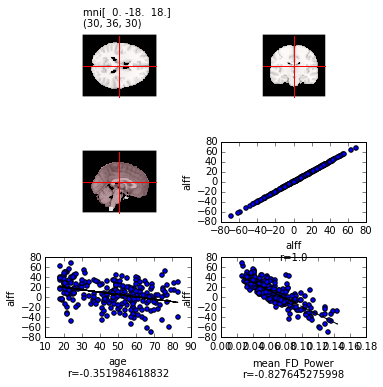

In [9]:
if 'pb_widget' in locals():
    v=(pb_widget.children[0].value,pb_widget.children[1].value,pb_widget.children[2].value)
else:
    v=tuple(np.array(data_stat.shape)//2)
pb_widget = widgets.interactive(plot_3d_data, 
                            x=widgets.IntSlider(min=0, max=data_stat.shape[0]-1, value=v[0]),
                            y=widgets.IntSlider(min=0, max=data_stat.shape[1]-1, value=v[1]),
                            z=widgets.IntSlider(min=0, max=data_stat.shape[2]-1, value=v[2])
                            )
display.display(pb_widget)



def btn_fct(btn):
    v=(pb_widget.children[0].value,pb_widget.children[1].value,pb_widget.children[2].value)
    coords_str=str(vox_2_mm(img_brain_template,v))
    print('save image' + str(vox_2_mm(img_brain_template,v)))
    file_name=os.path.join(fig_path, raw1_name + '_' + raw2_name + coords_str + '.pdf' )
    global_dict['fig'].savefig(file_name)
    
btn = widgets.Button(description="save")
btn.on_click(btn_fct)
display.display(btn)


In [11]:
from scipy.stats import pearsonr

sx_=df.mean_FD_Power
sy_=data_raw1[22,45,30, :]
pearsonr(sx_,sy_)

(0.089023563752383003, 0.15472856314512981)

In [18]:
img_brain_template.get_affine()
#vox_2_mm(img_brain_template, (2,3,4))
nib.affines.apply_affine(img_brain_template.get_affine(), (2,3,4))


array([  84., -117.,  -60.])

In [7]:
    
    ax = axes[3, 0]
    sx=df.age
    sy=data_raw1[x, y, z, :]
    sz=df.mean_FD_Power
    sx, sy = residualize(sx,sy,sz)
    ax.scatter(sx, sy)
    ax.set_xlabel('age.FDres' + '\nr=' + str(np.corrcoef(sx,sy)[1,0]))
    ax.set_ylabel(raw1_name)    
    fig.set_size_inches(5, 5)
    m,b = np.polyfit(sx, sy, 1) 
    ax.plot(sx, m*sx+b, '--k')
    
    ax = axes[3, 1]
    sx=df.mean_FD_Power
    sy=data_raw1[x, y, z, :]
    sz=df.mean_FD_Power
    sx, sy = residualize(sx,sy,sz)
    ax.scatter(sx, sy)
    ax.set_xlabel('mean_FD_Power.ageRes' + '\nr=' + str(np.corrcoef(sx,sy)[1,0]))
    ax.set_ylabel(raw1_name)    
    fig.set_size_inches(5, 5)
    m,b = np.polyfit(sx, sy, 1) 
    ax.plot(sx, m*sx+b, '--k')

NameError: name 'axes' is not defined